In [1]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.datasets import make_regression
import xgboost as xgb
import lightgbm as lgb
import warnings
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


warnings.filterwarnings("ignore")


def MacroStackRegressor():
        #增加特征多样性与样本多样性
    clf2 = RFR(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=1412,n_jobs=8)
    #特征多样性，稍微上调特征数量
    clf3 = GBR(n_estimators= 100,max_features=16,random_state=1412) 

    #增加算法多样性，新增决策树与KNN
    clf4 = DTR(max_depth=8,random_state=1412)
    clf5 = KNNR(n_neighbors=10,n_jobs=8)
    clf6 = GaussianNB()

    #新增随机多样性，相同的算法更换随机数种子
    clf7 = RFR(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=4869,n_jobs=8, min_impurity_decrease=0.0025)
    clf8 = GBR(n_estimators= 100,max_features=16,random_state=4869)

    final_estimator = RFR(n_estimators= 100,max_features="sqrt",max_samples=0.9, random_state=3217,n_jobs=8, min_impurity_decrease=0.0025)

    estimators = [("RandomForest", clf2)
                  , ("GBDT",clf3), ("Decision Tree", clf4), ("KNN",clf5) 
                  , ("RandomForest2", clf7), ("GBDT2", clf8)]

    return StackingRegressor(estimators, final_estimator)


    
    


def matrix(truth, prediction):
    mse_stack = mean_squared_error(truth, prediction)
    mae_stack = mean_absolute_error(truth, prediction)
    r2_stack = r2_score(truth, prediction)
    print('mse: %.4f' % mse_stack)
    print('mae: %.4f' % mae_stack)
    print('r2: %.4f' % r2_stack)
    print('precision: %.4f' % precision_score(truth, preprocessing.binarize(pd.DataFrame(prediction), threshold=0.5)))


考虑数据输入:
开始时间，结束时间(elapsed_time和/或point_number)，set情况(set_no)，双方局外胜率(rate)，双方当前得分(p1_score, p2_score)，开始时game获胜情况(p1_games, p2_games)，发球手(server)
输出：
game_victor

In [2]:
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sklearn.model_selection
from notebooks.MultiRegression import test_dataset

use_columns = ["game_no", "point_no", "set_no", "p1_score", "p2_score", "p1_games", "p2_games", "server"]

data = pd.read_csv("../data/data.csv")

x = data[use_columns]
x[["elo", "match_prob"]]= pd.read_csv("../data/elo_data.csv")[["sf_elo_diff_538", "match_prob_kls_EM"]]

x["server"] = x["server"].replace(2, 0)

y = data["point_victor"]

y = pd.DataFrame(y, columns=["point_victor"])
y = y.replace(2, 0)

In [49]:

print("\nStacking:")

kfold = KFold(n_splits=5, shuffle=True, random_state=0)
predictions = pd.DataFrame(data=np.zeros(x.shape[0]), columns=["Macro Predictions"])

for train_index,test_index in kfold.split(x,y):
    x_train = x.iloc[train_index]
    y_train = y.iloc[train_index]
    x_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    
    stack = MacroStackRegressor()
    stack.fit(x_train, y_train)
    prediction = stack.predict(x_test)
    matrix(y_test, prediction)
    pred = pd.DataFrame(prediction, index=test_index, columns=["Macro Predictions"])
    
    
    predictions["Macro Predictions"][test_index] = pred["Macro Predictions"]
    # plt.plot(pred_stack[0:50], label="Stack")

print(predictions)
# predictions.to_csv("../data/macro_data.csv")


Stacking:
mse: 0.2147
mae: 0.4377
r2: 0.1402
precision: 0.6958
mse: 0.2179
mae: 0.4406
r2: 0.1280
precision: 0.6983
mse: 0.2232
mae: 0.4430
r2: 0.1072
precision: 0.6624
mse: 0.2206
mae: 0.4420
r2: 0.1170
precision: 0.6890
mse: 0.2226
mae: 0.4433
r2: 0.1091
precision: 0.6797
      Macro Predictions
0              0.661707
1              0.498120
2              0.683251
3              0.691062
4              0.670422
...                 ...
7225           0.691062
7226           0.678561
7227           0.684476
7228           0.510057
7229           0.513310

[7230 rows x 1 columns]


[-1.9702443811861952]


(-15.0, 15.0)

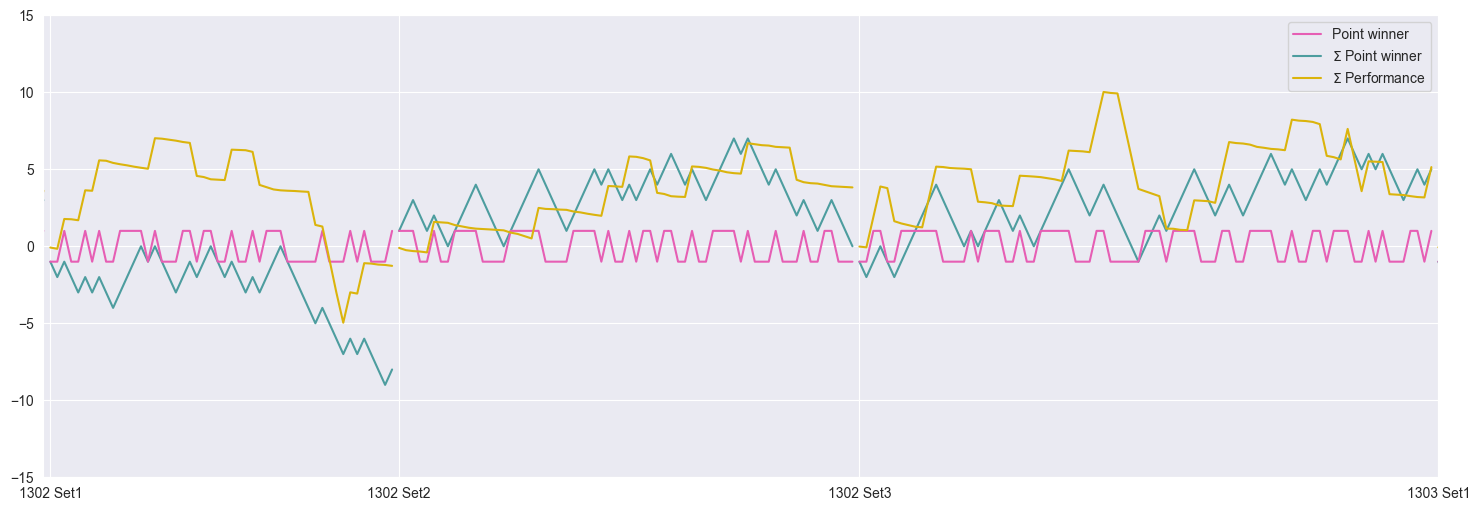

In [253]:
import seaborn as sns

color = sns.diverging_palette(333, 195, s=74, l=60, n=7, sep=1, as_cmap=False)
color1 = sns.xkcd_rgb["gold"]

plt.figure(figsize=(18, 6))

combine_test = pd.read_csv('../data/combine_test.csv')

micro = np.asarray(combine_test["predicted_probability"])
macro = np.asarray(predictions["Macro Predictions"])
server = np.asarray(x["server"])

server = server*2-1

pt_winner = np.asarray(y.T)[0]
pt_winner = pt_winner*2-1
pt_winner_integral = [pt_winner[0]]


performance = pt_winner - (macro-0.5)*6
performance_integral = [performance[0]]
print(performance_integral)

lastSet = 1
span = 0
xtick_index = [0]
xtick_content = [data["match_id"][0][-4:]+" Set"+str(data["set_no"][0])]
for i in range(0, len(pt_winner)-1):
    if lastSet != data["set_no"][i]:
        lastSet = data["set_no"][i]
        
        plt.plot(range(i-span, i+1), pt_winner_integral[i-span: i+1], color=color[6])
        plt.plot(range(i-span, i+1), pt_winner[i-span: i+1], color=color[0])
        plt.plot(range(i-span, i+1), performance_integral[i-span: i+1], color=color1)
        
        
        xtick_index.append(i+1)
        xtick_content.append(data["match_id"][i][-4:]+" Set"+str(data["set_no"][i]))
        
        pt_winner_integral.append(pt_winner[i+1])
        performance_integral.append(performance[i+1])
        
        span=0
    else:
        pt_winner_integral.append(pt_winner_integral[i]+pt_winner[i+1])
        performance_integral.append(performance_integral[i]+performance[i+1])
        span += 1

plt.xticks(xtick_index, xtick_content)
plt.plot(pt_winner[0], label="Point winner", color=color[0])
plt.plot(pt_winner[0], label="$\Sigma$ Point winner", color=color[6])
plt.plot(performance_integral[0], label="$\Sigma$ Performance", color=color1)

plt.legend()
plt.xlim(299, 499)
plt.ylim(-15, 15)


# # performance = (micro-0.515)*40 - (macro-0.5)/0.32
# performance = pt_winner - (macro-0.5)/0.32
# performance_integral = []
# 
# for i in range(len(performance)):
#     performance_integral.append(performance[0: i].sum()/5)
# 


# plt.ylim(-3, 3)
# plt.plot(pt_winner_integral, color=color[6])


# performance = np.asarray(y_test.T)[0]-macro/0.64

# print(np.asarray(y_test.T)[0])
# print(micro)
# scaler = preprocessing.StandardScaler()

# micro = np.asarray(micro).reshape(-1, 1)
# scaler.fit(micro)
# performance = micro - macro


(-5.0, 5.0)

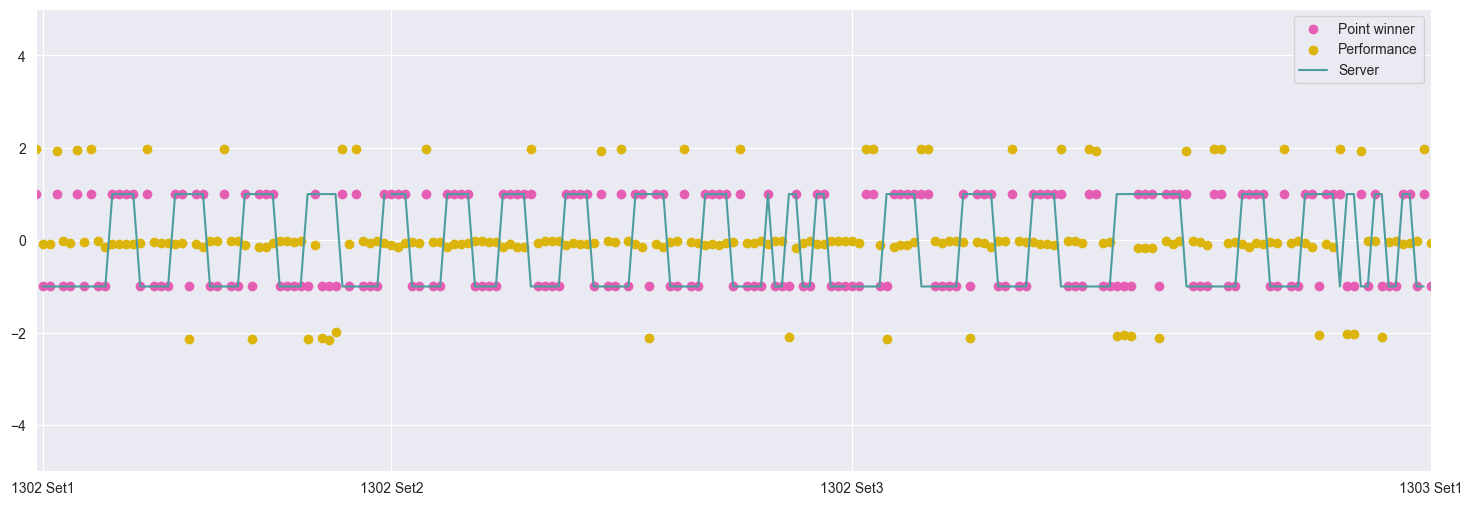

In [252]:
plt.figure(figsize=(18, 6))

lastSet = 1
span = 0
for i in range(0, len(pt_winner)-1):
    if lastSet != data["set_no"][i]:
        lastSet = data["set_no"][i]
        
        # plt.plot(range(i-span, i+1), pt_winner[i-span: i+1], color=color[0])
        # plt.plot(range(i-span, i+1), performance[i-span: i+1], color=color1)
        plt.plot(range(i-span, i+1), server[i-span: i+1], color=color[6])
        
        span=0
    else:
        span += 1

plt.xticks(xtick_index, xtick_content)
plt.scatter(range(0, len(pt_winner)), pt_winner, color=color[0], label="Point winner")
# plt.plot(pt_winner[0], label="Point winner", color=color[0])
plt.scatter(range(0, len(pt_winner)), performance, label="Performance", color=color1)
plt.plot(server[0], label="Server", color=color[6])

plt.yticks()
plt.legend()
plt.xlim(299, 499)
plt.ylim(-5, 5)


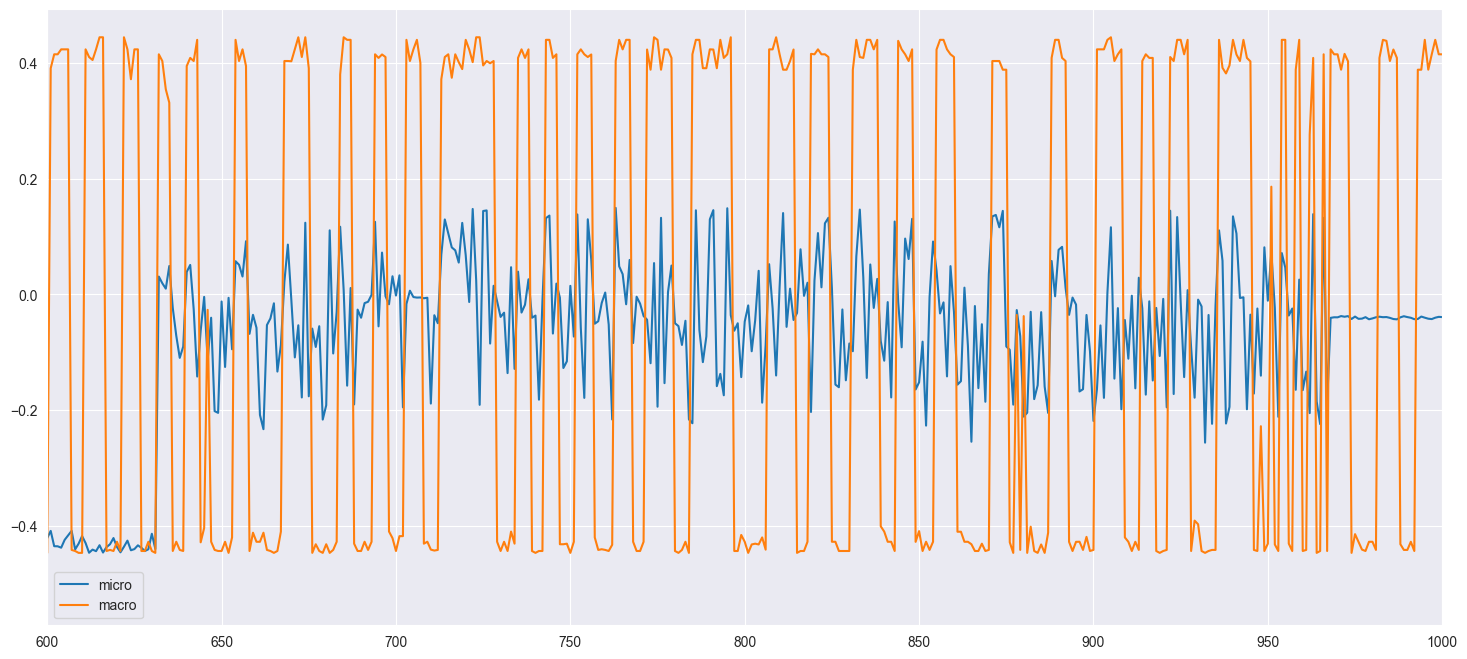

In [244]:

# TODO:积分， performance单独图和对比图
# plt.plot(performance_integral, label="performance_integral")
plt.figure(figsize=(18, 8))
# plt.plot(performance, label="performance")
# plt.plot(pt_winner_integral, label="point winner_integral")
# plt.plot(np.asarray(data["server"])-1.5, label="server")
plt.plot((micro-0.55)*2, label="micro")
plt.plot((macro-0.515)*2.5, label="macro")
plt.xlim(left = 600, right = 1000)
# plt.ylim(bottom = -5, top = 5)

plt.yticks()
plt.legend()
plt.show()
